In [1]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import torch
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time
import pandas as pd
%matplotlib inline

# from netgan.netgan import *
# from netgan import utils

from net.utils import *
from net import utils_netgan as utils
import net.net as net

#### Load the data

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [5]:
rw_len = 16
batch_size = 128
mixing_coeff = 1

In [6]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

In [7]:
train_graph.shape[0]

2810

#### Create our Net model

In [8]:
netmodel = net.Net(N=_N,
                   H=12,
                   affine=True,
                   loss_fn=torch.nn.functional.cross_entropy,
                   loggers=[net.GraphStatisticsLogger(train_graph, val_ones, val_zeros,
                                                      mixing_coeff=mixing_coeff, log_every=50),
                            net.BasicPrintLogger(print_every=100)])

#### Train our model

In [9]:
netmodel.train(generator=net_walker(walker),
               steps=100,
               optimizer_fn=torch.optim.Adam,
               optimizer_args={'lr': 0.01})

Step: 99, Loss: 5.86540


#### Create model and train with stopping

In [10]:
# netmodel = net.Net(N=_N,
#                    H=15,
#                    affine=False,
#                    loss_fn=torch.nn.functional.cross_entropy,
#                    stoppers=[net.OverlapStopper(train_graph, 
#                                                 mixing_coeff=mixing_coeff,
#                                                 test_every=50)])

In [11]:
# netmodel.train(generator=net_walker(walker),
#                steps=200,
#                optimizer_fn=torch.optim.Adam,
#                optimizer_args={'lr': 0.01},
#                EO_criterion=0.3)

#### Build score matrix from trained model

In [12]:
transition_matrix = netmodel(torch.arange(start=0,end=_N, dtype=int))

scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                     symmetric=True,
                                                     mixing_coeff=mixing_coeff)
scores_matrix = sp.csr_matrix(scores_matrix)

#### Evaluate generalization via link prediction

In [13]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

print(roc_auc_score(test_labels, test_scores))
print(average_precision_score(test_labels, test_scores))

0.8790375000000001
0.8912839441684759


#### Build graph and evaluate graph statistics

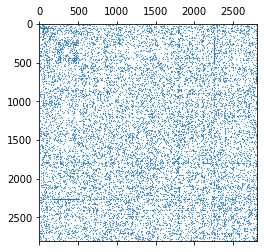

0.047471620227038186


In [14]:
sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())

plt.spy(sampled_graph, markersize=.2)
plt.show()

print(utils.edge_overlap(train_graph.toarray(), sampled_graph)/train_graph.sum())

In [15]:
statistics_sampled = utils.compute_graph_statistics(sampled_graph)
statistics_train = utils.compute_graph_statistics(train_graph.toarray())

In [16]:
df = pd.DataFrame([statistics_train, statistics_sampled], index=['CORA-ML', 'Our method'])

for index, row in df.iterrows():
    new_row = [f'{round(x, 4):,}' for x in list(row)]
    df.loc[index] = new_row

df[['d_max', 'assortativity', 'triangle_count', 
    'wedge_count', 'claw_count', 'power_law_exp', 
    'clustering_coefficient', 'rel_edge_distr_entropy', 
    'LCC', 'gini', 'cpl']]

,d_max,assortativity,triangle_count,wedge_count,claw_count,power_law_exp,clustering_coefficient,rel_edge_distr_entropy,LCC,gini,cpl
CORA-ML,238.0,-0.0763,"2,802.0","101,747.0","3,033,514.0",1.8551,0.0028,0.9407,"2,810.0",0.4819,5.63
Our method,164.0,-0.0202,146.0,"58,009.0","908,594.0",1.7381,0.0005,0.9689,"2,810.0",0.3542,4.7123


#### Plot graph statistics over time

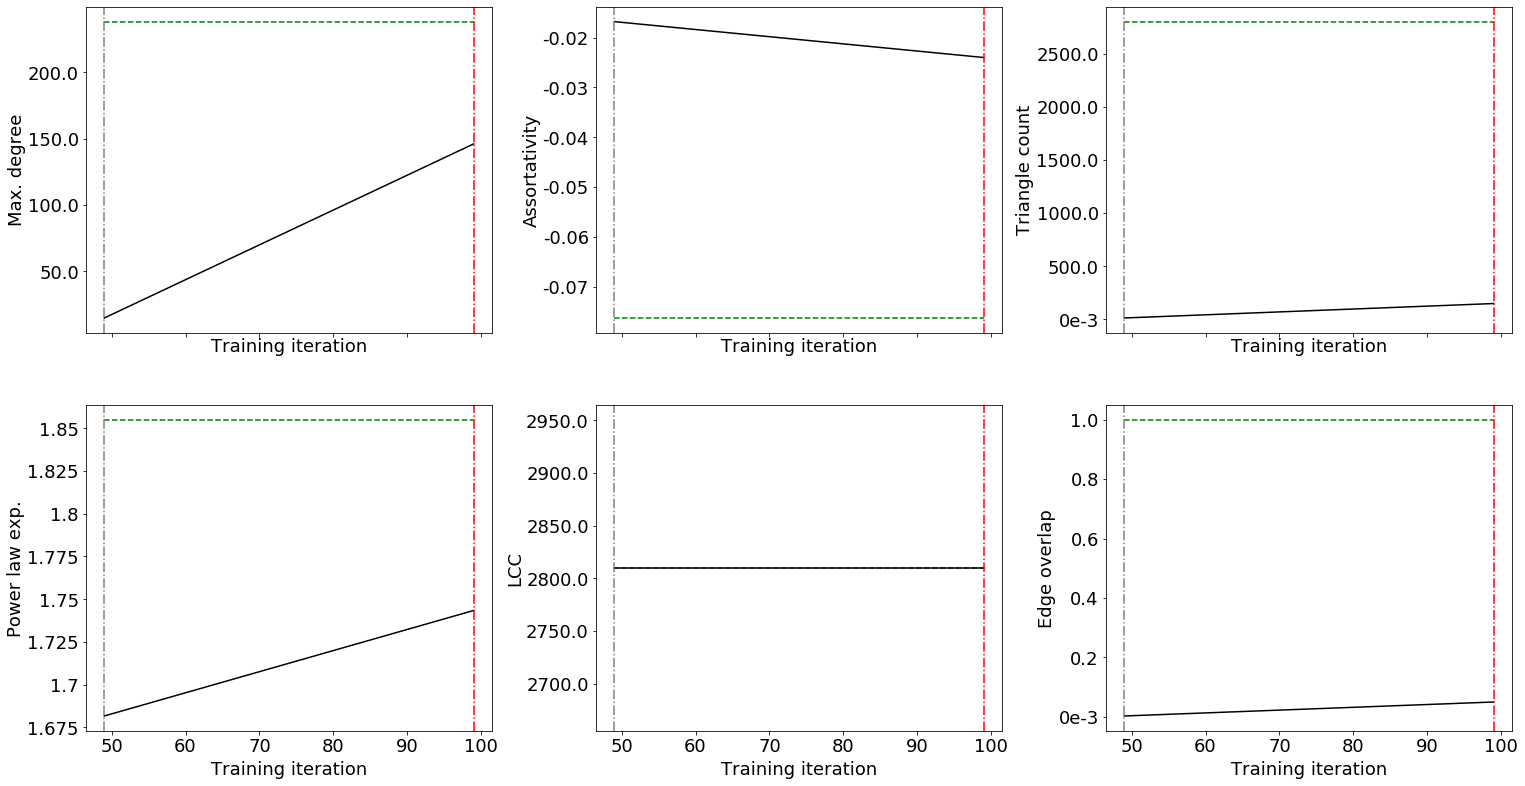

In [17]:
relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

relevant_keys = ['d_max', 'assortativity', 'triangle_count', 'power_law_exp', 'LCC', 'overlap']

netmodel.loggers[0].print_statistics(keys=relevant_keys, EO_criterion=0.52, max_patience_for_VAL=3)